If both players play perfectly, the second to move will win 3x3 boards, and the first will win 4x4 and 5x5 boards

In [3]:
from numpy.random import choice
from numpy.random import uniform
from numpy import array
import pandas as pd

# Not converging because rewards can be +2 or -2 even for bad/good moves

# Code an easy opponent for it to dominate!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
testing = False
# Given an n*n board...
n = 6
# How optimistic should AI be [0, 1]
initial = 0.01 #1/(2*n)
# alpha = Learning rate [0, 1]
al = 0.2
# gamma = discount factor [0, 1]
ga = 1
# epsilon = %chance picking randomly [0, 1]
ep = 0.1
# r = reward/punishment
r = 2.0

# Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
# Note that r will be zero for all non-terminal states

board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
                                                              
# Lists of locations on left and right-hand side of board
left_locs = [x for x in range(n**2) if (x+1)%n != 0]
right_locs = [x for x in range(n**2) if x%n != 0]
    
def printBoard(board, nums=False):
    for i in range(n):
        out = board[i*n:n+i*n] + '\t'
        
        # Print reference nums
        if nums:
            for j in range(i*n, (i+1)*n):
                out += str(j).rjust(3) 
                
        print(out)
    print('\n')

help(printBoard)
    
def checkWinner(board):
    if ('o' in board[:n]) | ('x' not in board):
        return 'o'
    if ('x' in board[-n:]) | ('o' not in board):
        return 'x'
    return False

def validMoves(board, player):
    '''Returns list of valid moves'''
    moves = []
    if player == 'o':
        opp, xo, start, end = 'x', -1, n, n**2
    else:
        opp, xo, start, end = 'o',  1, 0, (n-1)*n
        
    # Check whole board but one line for player
    for i in range(start, end):
        # Check if player exists in location
        if board[i] == player:
            # Check if player can move forward
            if board[i+n*xo] == '-':
                moves.append((i, i+n*xo))

            # Check if player can take right
            if i in left_locs:
                if board[i+n*xo+1] == opp:
                    moves.append((i, i+n*xo+1))

            # Check if player can take left
            if i in right_locs:
                if board[i+n*xo-1] == opp:
                    moves.append((i, i+n*xo-1))
                
    return moves

def flipBoard(board):
    out = ''
    for char in board[::-1]:
        if char == '-':
            out += '-'
        else:
            out += 'x' if char == 'o' else 'o'
        
    return ''.join(out)
                
def flipMove(board, action):
    c = n**2 - 1
    return move(board, (c-action[0], c-action[1]))

def move(board, action):
    lst = list(board)
    lst[action[1]] = board[action[0]]
    lst[action[0]] = '-'
    return ''.join(lst)

#########################################################################################

def vsPlayer(ai_first=True):
    board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
    test_table = pd.read_pickle(file)

    pastMoves = []
    while(not checkWinner(board)):
        if ai_first:
            # Add board to Q-Table if it is not there already
            if board not in test_table.index:
                test_table.loc[board] = [0] * test_table.shape[1]
                # For each possible move, assign initial value
                for col in validMoves(board, 'x'):
                    # Initialise new cols
                    if col not in list(test_table):
                        test_table[col] = [0] * test_table.shape[0]
                    test_table.loc[board, col] = initial

            # Get options
            options = list(test_table.loc[board].index)
            values = list(test_table.loc[board])
            options_values = zip(values, options)
            options_values = [(value, option) for value, option in options_values if value != 0]
            if options_values == []:
                winner = 'o'
                break
                
            # Get AI's Greedy Choice
            ai_choice = sorted(list(options_values), reverse=True)[0][1]
            pastMoves.append((board, ai_choice))

            # Act on AI's choice,
            board = move(board, ai_choice)
            if checkWinner(board):
                break
                
        printBoard(board, True)
        # Get player's choice and make move
        options = validMoves(board, 'o')
        if options == []:
            winner = 'x'
            break

        print("Choose one of these:", [(i, options[i]) for i in range(len(options))])
        player_choice = int(input("Enter choice: "))
        if player_choice not in [i for i in range(len(options))] or player_choice == '':
            print("You done goofed spud")
            break
        else:
            player_choice = options[player_choice]
            board = move(board, player_choice)
        printBoard(board, True)

        ai_first = True

    # Get winner
    winner = checkWinner(board) if checkWinner(board) else winner
    reward = r if winner == 'x' else -r
    # Update values, and save learning after each game
    # Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
    # a = Learning rate 
    pastMoves = pastMoves[::-1]
    last_action = True
    for pair in pastMoves:
        state, action = pair
        Q = test_table.at[state, action]

        # Last action gets set to reward value
        if last_action:
            test_table.at[state, action] = reward
            last_action = False

        else:
            next_state_max = max([value for value in test_table.loc[next_state]])
            test_table.at[state, action] = Q + al*(ga*next_state_max - Q)
            
        #state s becomes s'
        next_state = state

    # Save table
    test_table.to_pickle(file)

    # Print endgame
    print('\n')
    printBoard(board)
    print(winner, 'wins!')
    if not checkWinner(board):
        opp = 'x' if winner == 'o' else 'o'
        print(opp, 'ran out of moves!')

        
#########################################################################################

def vsSelf(verbose=False, crush=False, eps=ep):
    board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
    test_table = pd.read_pickle(file)

    xpastMoves = []
    opastMoves = []
    while(not checkWinner(board)):
        # Add board to Q-Table if it is not there already
        if board not in test_table.index:
            test_table.loc[board] = [0] * test_table.shape[1]
            # For each possible move, assign initial value
            for col in validMoves(board, 'x'):
                # Initialise new cols
                if col not in list(test_table):
                    test_table[col] = [0] * test_table.shape[0]
                test_table.loc[board, col] = initial
                
        # Get options
        options = list(test_table.loc[board].index)
        values = list(test_table.loc[board])
        options_values = zip(values, options)
        options_values = [(value, option) for value, option in options_values if value != 0]
        if options_values == []:
            winner = 'o'
            break
        
        if crush:
            ai_choice = sorted(options_values, reverse=True)[0][1]
        else:
            # Epsilon-Greedy check
            if uniform() < eps:
                # Choose randomly
                ai_choice = options_values[choice([i for i in range(len(options_values))], 1)[0]][1]
            else:
                # Choose greedily
                ai_choice = sorted(options_values, reverse=True)[0][1]
        xpastMoves.append((board, ai_choice))

        # Act on AI's choice,
        board = move(board, ai_choice)
        if checkWinner(board):
            break
        if verbose:
            printBoard(board, True)
            
        ################ DO SAME FOR OTHER INSTANCE ################
        
        flip_board = flipBoard(board)
        # Add board to Q-Table if it is not there already
        if flip_board not in test_table.index:
            test_table.loc[flip_board] = [0] * test_table.shape[1]
            # For each possible move, assign initial value
            for col in [move for move in validMoves(flip_board, 'x')]:
                # Initialise new cols
                if col not in list(test_table):
                    test_table[col] = [0] * test_table.shape[0]
                test_table.loc[flip_board, col] = initial

        # Get options
        options = list(test_table.loc[flip_board].index)
        values = list(test_table.loc[flip_board])
        options_values = zip(values, options)
        options_values = [(value, option) for value, option in options_values if value != 0]
        if options_values == []:
            winner = 'x'
            break
        
        if crush:
            ai_choice = sorted(options_values, reverse=True)[0][1]
        else:
            # Epsilon-Greedy check
            if uniform() < eps:
                # Choose randomly
                ai_choice = options_values[choice([i for i in range(len(options_values))], 1)[0]][1]
            else:
                # Choose greedily
                ai_choice = sorted(options_values, reverse=True)[0][1]
        opastMoves.append((flip_board, ai_choice))

        # Act on AI's choice,
        board = flipMove(board, ai_choice)
        if checkWinner(board):
            break
        if verbose:
            printBoard(board, True)

    # Get winner
    winner = checkWinner(board) if checkWinner(board) else winner
    reward = r if winner == 'x' else -r
    # Update values, and save learning after each game
    # Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
    # a = Learning rate 
    xpastMoves = xpastMoves[::-1]
    last_action = True
    for pair in xpastMoves:
        state, action = pair
        Q = test_table.at[state, action]

        # Last action gets set to reward value
        if last_action:
            test_table.at[state, action] = reward
            last_action = False

        else:
            next_state_max = max([value for value in test_table.loc[next_state]])
            test_table.at[state, action] = Q + al*(ga*next_state_max - Q)
            
        #state s becomes s'
        next_state = state
        #print('Updated', state, action, 'from', Q, 'to', test_table.at[state, action])

    
    reward = r if winner == 'o' else -r
    # Update values, and save learning after each game
    # Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
    # a = Learning rate 
    opastMoves = opastMoves[::-1]
    last_action = True
    for pair in opastMoves:
        state, action = pair
        Q = test_table.at[state, action]
        # Last action gets set to reward value
        if last_action:
            test_table.at[state, action] = reward
            last_action = False

        else:
            next_state_max = max([value for value in test_table.loc[next_state]])
            test_table.at[state, action] = Q + al*(ga*next_state_max - Q)
        
        #state s becomes s'
        next_state = state
  
    test_table.to_pickle(file)
    if verbose:
        print(test_table)

        # Print endgame
        print('\n')
        printBoard(board)
        print(winner, 'wins!')
        if not checkWinner(board):
            opp = 'x' if winner == 'o' else 'o'
            print(opp, 'ran out of moves!')
            
    return 1 if winner=='x' else 0

# Q-Table name
#states  | Option1 | Option2 | Option3 | ... 
#state 1 |  value  |  value  |  value  | ... 
#state 2 |  value  |  value  |  value  | ... 
#state 3 |  value  |  value  |  value  | ... 
#  ...   |   ...   |   ...   |   ...   | ...

if testing:
    file = 'new' + str(n) + 'table.pkl'
    board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
    test_table = pd.DataFrame(data=[[initial]*n], index = [board], columns = validMoves(board, 'x'))
    test_table.to_pickle(file)
    test_table = pd.read_pickle(file)
else:
    file = str(n) + 'table.pkl'
    test_table = pd.read_pickle(file)

Help on function printBoard in module __main__:

printBoard(board, nums=False)



In [ ]:
eps_start = 0.3
c = 1000
numerator = c*eps_start

trials = 1000
for i in range(trials):
    epsilon = numerator / (i+c)
    if i in [j*trials//20 for j in range(1,20)]:
        print(str(i) + '|', end='')
    vsSelf(eps=epsilon)
print("Done!")

test_table = pd.read_pickle(file)
print("Before and after:\n(136492, 52), (190492, 52), (215851, 52)")
test_table.shape

In [ ]:
vsPlayer(ai_first=False)

xxxxxx	  0  1  2  3  4  5
------	  6  7  8  9 10 11
------	 12 13 14 15 16 17
------	 18 19 20 21 22 23
------	 24 25 26 27 28 29
oooooo	 30 31 32 33 34 35


Choose one of these: [(0, (30, 24)), (1, (31, 25)), (2, (32, 26)), (3, (33, 27)), (4, (34, 28)), (5, (35, 29))]


In [36]:
#Q-Value convergence
board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
trials = 100
for i in range(trials):
    vsSelf(eps=1)
    test_table = pd.read_pickle(file)
    if i%(trials//100) == 0:
        x = vsSelf(crush=True)
        initial_moves = [(i, i+n) for i in range(n)]
        L = list(test_table.loc[board, initial_moves])
        L = [round(i, 3) for i in L]
        print(' '.join([str(L[i]) for i in range(n)]), x)
print('Done!')
#vsPlayer(ai_first=False)

0.197 0.137 0.124 0.162 0.227 0.172 1
0.197 0.137 0.124 0.16 0.225 0.172 1
0.197 0.137 0.124 0.16 0.52 0.172 1
0.189 0.137 0.124 0.16 0.462 0.172 1
0.189 0.118 0.124 0.16 0.416 0.172 1
0.274 0.118 0.124 0.16 0.382 0.172 1
0.274 0.118 0.124 0.16 0.356 0.197 1
0.274 0.118 0.124 0.16 0.337 0.17 1
0.274 0.118 0.124 0.16 0.323 0.184 1
0.274 0.118 0.124 0.16 0.275 0.184 0
0.274 0.118 0.124 0.16 0.277 0.158 1
0.274 0.1 0.124 0.16 0.282 0.158 1
0.274 0.086 0.124 0.16 0.287 0.158 0
0.342 0.086 0.124 0.16 0.294 0.158 1
0.463 0.086 0.124 0.16 0.294 0.158 1
0.402 0.075 0.124 0.16 0.294 0.158 1
0.354 0.075 0.124 0.16 0.237 0.158 1
0.471 0.075 0.124 0.16 0.237 0.158 1
0.59 0.075 0.124 0.16 0.192 0.158 1
0.504 0.066 0.124 0.16 0.192 0.158 1
0.557 0.066 0.124 0.16 0.192 0.158 1
0.478 0.066 0.124 0.16 0.173 0.158 1
0.414 0.067 0.124 0.16 0.173 0.158 1
0.363 0.061 0.124 0.16 0.173 0.158 1
0.263 0.061 0.124 0.16 0.173 0.158 1
0.242 0.061 0.122 0.16 0.173 0.158 1
0.225 0.061 0.122 0.16 0.14 0.158 1
0.211 

In [6]:
test_table.loc[['xxx-o-o-o']]

,"(0, 3)","(1, 4)","(2, 5)","(1, 3)","(5, 7)","(0, 4)","(2, 4)","(4, 7)","(4, 8)","(1, 5)","(3, 6)","(3, 7)","(4, 6)","(5, 8)"
xxx-o-o-o,-2.0,0.0,-2.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
# Don't actually want normal AI to train against Dumbo as it will learn how to beat a randomly choosing opponent which is 
# not the same as learning how to beat an intelligent opponenet.

def vsDumbo(ai_first=True, verbose=False, ep=ep, al=al, crush=False):
    board = 'x'*n + ''.join(['-'*n for i in range(n-2)]) + 'o'*n
    test_table = pd.read_pickle(file)

    xpastMoves = []
    opastMoves = []
    while(not checkWinner(board)):
        if ai_first:
            # Add board to Q-Table if it is not there already
            if board not in test_table.index:
                test_table.loc[board] = [0] * test_table.shape[1]
                # For each possible move, assign initial value
                for col in validMoves(board, 'x'):
                    # Initialise new cols
                    if col not in list(test_table):
                        test_table[col] = [0] * test_table.shape[0]
                    test_table.loc[board, col] = initial

            # Get options
            options = list(test_table.loc[board].index)
            values = list(test_table.loc[board])
            options_values = zip(values, options)
            options_values = [(value, option) for value, option in options_values if value != 0]
            if options_values == []:
                winner = 'o'
                break

            # Epsilon-Greedy check
            if crush:
                ai_choice = sorted(options_values, reverse=True)[0][1]
            else:
                if uniform() < ep:
                    # Choose randomly
                    ai_choice = options_values[choice([i for i in range(len(options_values))], 1)[0]][1]
                else:
                    # Choose greedily
                    ai_choice = sorted(options_values, reverse=True)[0][1]
            xpastMoves.append((board, ai_choice))

            # Act on AI's choice,
            board = move(board, ai_choice)
            if checkWinner(board):
                break
            if verbose:
                printBoard(board, True)
        ai_first = True    
        ################ DO SAME FOR OTHER INSTANCE ################
        
        flip_board = flipBoard(board)
        # Add board to Q-Table if it is not there already
        if flip_board not in test_table.index:
            test_table.loc[flip_board] = [0] * test_table.shape[1]
            # For each possible move, assign initial value
            for col in [move for move in validMoves(flip_board, 'x')]:
                # Initialise new cols
                if col not in list(test_table):
                    test_table[col] = [0] * test_table.shape[0]
                test_table.loc[flip_board, col] = initial

        # Get options
        options = list(test_table.loc[flip_board].index)
        values = list(test_table.loc[flip_board])
        options_values = zip(values, options)
        options_values = [(value, option) for value, option in options_values if value != 0]
        if options_values == []:
            winner = 'x'
            break
        
        # Choose randomly
        ai_choice = options_values[choice([i for i in range(len(options_values))], 1)[0]][1]
        opastMoves.append((flip_board, ai_choice))

        # Act on AI's choice,
        board = flipMove(board, ai_choice)
        if checkWinner(board):
            break
        if verbose:
            printBoard(board, True)

    # Get winner
    winner = checkWinner(board) if checkWinner(board) else winner
    reward = r if winner == 'x' else -r
    # Update values, and save learning after each game
    # Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
    # a = Learning rate 
    xpastMoves = xpastMoves[::-1]
    last_action = True
    for pair in xpastMoves:
        state, action = pair
        Q = test_table.at[state, action]

        # Last action gets set to reward value
        if last_action:
            test_table.at[state, action] = reward
            last_action = False

        else:
            next_state_max = max([value for value in test_table.loc[next_state]])
            test_table.at[state, action] = Q + al*(ga*next_state_max - Q)
            
        #state s becomes s'
        next_state = state

    
    reward = r if winner == 'o' else -r
    # Update values, and save learning after each game
    # Q learning -> Q(st, at) := Q(st, at) + al*(r + ga*max(Q(s', a) - Q(st, at)))
    # a = Learning rate 
    opastMoves = opastMoves[::-1]
    last_action = True
    for pair in opastMoves:
        state, action = pair
        Q = test_table.at[state, action]
        # Last action gets set to reward value
        if last_action:
            test_table.at[state, action] = reward
            last_action = False

        else:
            next_state_max = max([value for value in test_table.loc[next_state]])
            test_table.at[state, action] = Q + al*(ga*next_state_max - Q)
        
        #state s becomes s'
        next_state = state
  
    test_table.to_pickle(file)
    if verbose:
        print(test_table)

        # Print endgame
        print('\n')
        printBoard(board)
        print(winner, 'wins!')
        if not checkWinner(board):
            opp = 'x' if winner == 'o' else 'o'
            print(opp, 'ran out of moves!')
            
    return 1 if winner=='x' else 0

In [9]:
trials = 1000

total = 0
games = 0
for i in range(trials):
    if i%10 == 0:
        win = vsSelf(verbose=False, crush=True)
        total += win
        games += 1
        print(win, total/games)
    else:
        vsSelf(verbose=False)
print("Done!")

'''trials = 1000

total_first = 0
total_second = 0
games = 0
for i in range(trials):
    if i%10 == 0:
        games += 1
        total_first += vsDumbo(ai_first=True, verbose=False, ep=ep, al=al, crush=True)
        total_second += vsDumbo(ai_first=False, verbose=False, ep=ep, al=al, crush=True)
        print(total_first/games, total_second/games)
    else:
        vsDumbo(ai_first=True, verbose=False, ep=ep, al=al, crush=False)
        vsDumbo(ai_first=False, verbose=False, ep=ep, al=al, crush=False)
print("Done!")
'''
'''
for eps in eps_alp:
    i = 0.0
    lst = list(eps_alp.loc[round(eps*0.2, 2)])
    for win in lst:
        print(round(eps*0.2, 2), round(i, 2), win)
        i += 0.05
        '''

0 0.0
0 0.0
0 0.0
0 0.0
0 0.0
1 0.16666666666666666
1 0.2857142857142857
0 0.25
0 0.2222222222222222
0 0.2
0 0.18181818181818182
0 0.16666666666666666
1 0.23076923076923078
1 0.2857142857142857
0 0.26666666666666666
0 0.25
0 0.23529411764705882
0 0.2222222222222222
1 0.2631578947368421
1 0.3
1 0.3333333333333333
1 0.36363636363636365
1 0.391304347826087
1 0.4166666666666667
1 0.44
1 0.46153846153846156
1 0.48148148148148145
1 0.5
1 0.5172413793103449
1 0.5333333333333333
1 0.5483870967741935
1 0.5625
1 0.5757575757575758
1 0.5882352941176471
1 0.6
1 0.6111111111111112
1 0.6216216216216216
1 0.631578947368421
1 0.6410256410256411
0 0.625
0 0.6097560975609756
0 0.5952380952380952
0 0.5813953488372093
0 0.5681818181818182
1 0.5777777777777777
0 0.5652173913043478
1 0.574468085106383
1 0.5833333333333334
0 0.5714285714285714
1 0.58
1 0.5882352941176471
1 0.5961538461538461
0 0.5849056603773585
0 0.5740740740740741
1 0.5818181818181818
0 0.5714285714285714
0 0.5614035087719298
0 0.551724137

'trials = 1000\n\ntotal_first = 0\ntotal_second = 0\ngames = 0\nfor i in range(trials):\n    if i%10 == 0:\n        games += 1\n        total_first += vsDumbo(ai_first=True, verbose=False, ep=ep, al=al, crush=True)\n        total_second += vsDumbo(ai_first=False, verbose=False, ep=ep, al=al, crush=True)\n        print(total_first/games, total_second/games)\n    else:\n        vsDumbo(ai_first=True, verbose=False, ep=ep, al=al, crush=False)\n        vsDumbo(ai_first=False, verbose=False, ep=ep, al=al, crush=False)\nprint("Done!")\n'

In [ ]:
from itertools import permutations

#3x3 board - 6799 perms, 73 real
#4x4 board - 

#xxx
#---
#ooo

#9! / (3!*3!*3! ways of arranging chars) + 9!/(3!*2!*4!)
       
nn = 4
total = 0
for x in range(nn+1):
    print(x)
    for o in range(nn+1):
        board = 'x'*x + ''.join(['-' for i in range(nn**2 -x-o)]) + 'o'*o
        total += len(set(permutations(board, nn**2)))
print(total)

#len(set(permutations(board, nn**2)))

In [5]:
test_table

,"(0, 5)","(1, 6)","(2, 7)","(3, 8)","(4, 9)","(9, 14)","(14, 19)","(1, 5)","(8, 13)","(19, 23)",...,"(17, 22)","(17, 21)","(7, 13)","(11, 17)","(15, 20)","(11, 15)","(3, 9)","(15, 21)","(4, 8)","(16, 20)"
xxxxx---------------ooooo,1.134854,1.086943,1.522418,1.249655,1.151567,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxxx----------o-----oooo,0.875891,0.984953,1.063549,1.133537,1.017346,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxx-----x-----o-----oooo,1.185436,0.827169,1.210456,1.467913,0.000000,1.247158,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxx-----xo----------oooo,1.002722,0.776835,1.177019,0.992420,0.000000,0.487050,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxx----------xoo-----ooo,1.759319,0.812921,0.994754,1.070977,0.000000,0.000000,0.551994,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxx--o--xx-----------oooo,0.000000,1.164728,-2.000000,0.000000,0.000000,-2.000000,0.000000,0.125516,-1.876423,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxx------o-----o--x--ooo,0.119000,0.115704,0.201894,0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxxx------------o--oo-oo,0.874344,0.874093,0.875079,0.874258,0.872700,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xx-xx--x-------o-----oooo,0.746272,0.849349,0.000000,1.502749,1.180753,0.000000,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00
xxxx-----x--o-------oo-oo,0.736616,0.292822,0.394678,0.421461,0.000000,1.275695,0.000000,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00


In [41]:
import seaborn as sns

test = pd.read_csv('test.csv')
test.head()

,1.201,1.23,1.206,1.21,1.179
0,1.196,1.195,1.200,1.200,1.177
1,1.187,1.177,1.207,1.190,1.174
2,1.187,1.170,1.214,1.188,1.171
3,1.187,1.171,1.233,1.206,1.159
4,1.186,1.165,1.263,1.192,1.159


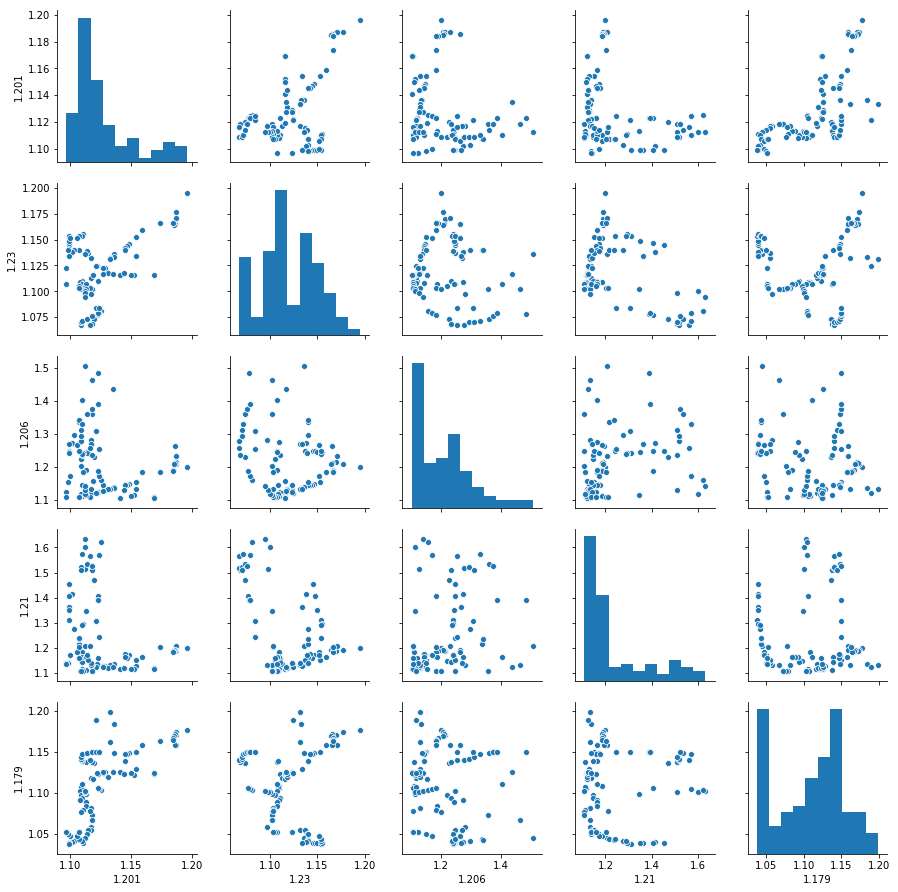

In [42]:
sns.pairplot(test)
plt.show()

In [37]:
(1,2, 3,)

(1, 2, 3)